In [1]:
import os
import time
import pprint

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

from typing import Dict, Text

plt.style.use('seaborn-whitegrid')

C:\Users\WNLAB\anaconda3\envs\ikar_hnm\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preprocessing

#### Load dataset

In [2]:
# Set seed for reproducibility
seed = 17
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
article_df = pd.read_csv('dataset/articles.csv')
# article_top_df = pd.read_csv('dataset/articles_ranked.csv')

customer_df = pd.read_csv('dataset/customers.csv')
trans_df = pd.read_csv('dataset/transactions_train.csv')

#### Use only top-K articles

In [4]:
TOP_K = 20000  # currently not used
N_SAMPLES = int(1e6)

In [5]:
# article_top_df.head(12)['article_id'].to_list()
# percentage = article_top_df["transaction_counts"][:TOP_K].sum() / article_top_df["transaction_counts"].sum()

In [6]:
# print(f"Top {TOP_K} most sold H&M articles only account for {percentage:.2%} of the total (sold) articles")

#### Get random N samples

In [7]:
trans_df = trans_df.sample(frac=1, random_state=seed)

In [8]:
trans_df = trans_df.head(N_SAMPLES)

In [9]:
len(trans_df.customer_id.unique()) / 1371980

0.3543295091765186

In [10]:
article_df.fillna(value='', inplace=True)

In [11]:
trans_df['t_dat'] = pd.to_datetime(trans_df['t_dat']).values.astype(int) / 10**9

In [12]:
trans_df.rename(columns={"t_dat":"timestamp"}, inplace=True)

In [13]:
article_map = dict(article_df[['article_id', 'prod_name']].values)

In [14]:
trans_df['prod_name'] = trans_df.article_id.map(article_map)

In [15]:
articles = tf.data.Dataset.from_tensor_slices(dict(article_df)).map(lambda x: {
    'article_id' : tf.strings.as_string(x['article_id']),
    'prod_name' : x['prod_name'],
})

trans = tf.data.Dataset.from_tensor_slices(dict(trans_df)).map(lambda x: {
    'customer_id' : x['customer_id'],
    'article_id' : tf.strings.as_string(x['article_id']),
    'prod_name' : x['prod_name'],
    'timestamp' : x['timestamp'],
})


#### Features Preprocessing

In [16]:
timestamps = np.concatenate(list(trans.map(lambda x: x["timestamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)

In [17]:
### USE THIS TO AVOID STRINGLOOKUP
article_ids = articles.map(lambda x: x['article_id']).batch(1_000)
unique_article_ids = np.unique(np.concatenate(list(article_ids)))

customer_ids = trans.map(lambda x: x['customer_id']).batch(1_000)
unique_customer_ids = np.unique(np.concatenate(list(customer_ids)))

## Two-tower Model

In [18]:
class CustomerModel(tf.keras.Model):
  def __init__(self, use_timestamps):
    super().__init__()

    self._use_timestamps = use_timestamps
    
    embedding_dim = 32
    
    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=unique_customer_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_customer_ids) + 1, embedding_dim),
    ])

    if use_timestamps:
      self.timestamp_embedding = tf.keras.Sequential([
          tf.keras.layers.Discretization(timestamp_buckets.tolist()),
          tf.keras.layers.Embedding(len(timestamp_buckets) + 1, embedding_dim),
      ])
      self.normalized_timestamp = tf.keras.layers.Normalization(
          axis=None
      )

      self.normalized_timestamp.adapt(timestamps)

  def call(self, inputs):
    print(input)
    if not self._use_timestamps:
      return self.user_embedding(inputs["customer_id"])

    return tf.concat([
        self.user_embedding(inputs["customer_id"]),
        self.timestamp_embedding(inputs["timestamp"]),
        tf.reshape(self.normalized_timestamp(inputs["timestamp"]), (-1, 1)),
    ], axis=1)

In [19]:
class ArticleModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    max_tokens = 10_000
    
    embedding_dim = 32

    self.article_id_embedding = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
          vocabulary=unique_article_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_article_ids) + 1, embedding_dim)
    ])

    self.article_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens)

    self.article_text_embedding = tf.keras.Sequential([
      self.article_vectorizer,
      tf.keras.layers.Embedding(max_tokens, embedding_dim, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.article_vectorizer.adapt(articles.map(lambda x: x["prod_name"]))

  def call(self, inputs):
    return tf.concat([
        self.article_id_embedding(inputs["article_id"]),
        self.article_text_embedding(inputs["prod_name"]),
    ], axis=1)

In [20]:
class HNMModel(tfrs.models.Model):

  def __init__(self, use_timestamps):
    super().__init__()
    self.query_model = tf.keras.Sequential([
      CustomerModel(use_timestamps),
      tf.keras.layers.Dense(32)
    ])
    self.candidate_model = tf.keras.Sequential([
      ArticleModel(),
      tf.keras.layers.Dense(32)
    ])

    self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=articles.batch(128).map(self.candidate_model),
        ),
    )

  def compute_loss(self, features, training=False):
    query_embedding = self.query_model({
        "customer_id": features["customer_id"],
        "timestamp": features["timestamp"],
    })
    candidate_embedding = self.candidate_model({
        "article_id": features["article_id"],
        "prod_name": features["prod_name"],
    })

    return self.task(query_embedding, candidate_embedding)

## Model Training

In [31]:
EVAL_FREQ = 5
EPOCHS = 40
INIT_EPOCH = 20  # set to latest epoch when resuming from checkpoint

In [22]:
shuffled = trans.shuffle(trans_df.shape[0], seed=seed, reshuffle_each_iteration=False)

train = shuffled.take(800_000)
test = shuffled.skip(800_000).take(200_000)

cached_train = train.shuffle(800_000).batch(2048)
cached_test = test.batch(4096).cache()

In [23]:
checkpoint_path = "checkpoints/vanilla_1_random/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1,
    period=EVAL_FREQ)

In [32]:
# Load model
model = HNMModel(use_timestamps=False)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

if INIT_EPOCH > 0:
    # Load trained model weights
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    model.load_weights(latest)

wo_timestamp_hist = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=EVAL_FREQ,
    epochs=EPOCHS,
    initial_epoch=INIT_EPOCH,
    callbacks=[cp_callback])

Epoch 21/40
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000020B819919D0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000020B819919D0>>
391/391 [==============================] - 1638s 4s/step - factorized_top_k/top_1_categorical_accuracy: 0.3674 - factorized_top_k/top_5_categorical_accuracy: 0.7402 - factorized_top_k/top_10_categorical_accuracy: 0.8302 - factorized_top_k/top_50_categorical_accuracy: 0.9359 - factorized_top_k/top_100_categorical_accuracy: 0.9577 - loss: 1518.2631 - regularization_loss: 0.0000e+00 - total_loss: 1518.2631
Epoch 22/40
391/391 [==============================] - 1702s 4s/step - factorized_top_k/top_1_categorical_accuracy: 0.3676 - factorized_top_k/top_5_categorical_accuracy: 0.7449 - factorized_top_k/top_10_categorical_accuracy: 0.8355 - factorized_top_k/top_50_categorical_accuracy: 0.9397 - factorized_top_k/top_100_categorical_accuracy: 0.9599 - loss: 1483.1117 - regularization_loss:

Epoch 31/40
391/391 [==============================] - 2560s 7s/step - factorized_top_k/top_1_categorical_accuracy: 0.3669 - factorized_top_k/top_5_categorical_accuracy: 0.7786 - factorized_top_k/top_10_categorical_accuracy: 0.8702 - factorized_top_k/top_50_categorical_accuracy: 0.9607 - factorized_top_k/top_100_categorical_accuracy: 0.9746 - loss: 1240.9666 - regularization_loss: 0.0000e+00 - total_loss: 1240.9666
Epoch 32/40
391/391 [==============================] - 1970s 5s/step - factorized_top_k/top_1_categorical_accuracy: 0.3680 - factorized_top_k/top_5_categorical_accuracy: 0.7812 - factorized_top_k/top_10_categorical_accuracy: 0.8732 - factorized_top_k/top_50_categorical_accuracy: 0.9622 - factorized_top_k/top_100_categorical_accuracy: 0.9756 - loss: 1221.9384 - regularization_loss: 0.0000e+00 - total_loss: 1221.9384
Epoch 33/40
391/391 [==============================] - 2486s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.3673 - factorized_top_k/top_5_categorical_ac

KeyboardInterrupt: 

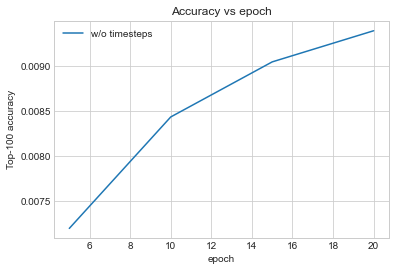

In [25]:
num_validation_runs = len(wo_timestamp_hist.history["val_factorized_top_k/top_10_categorical_accuracy"])
epochs = [(x + 1)* EVAL_FREQ for x in range(num_validation_runs)]

plt.plot(epochs, wo_timestamp_hist.history["val_factorized_top_k/top_10_categorical_accuracy"], label="w/o timesteps")
# plt.plot(epochs, w_timestamp_hist.history["val_factorized_top_k/top_10_categorical_accuracy"], label="w/ timesteps")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

## Get Recommendation

In [26]:
articles.batch(100).map(lambda x: model.candidate_model({
    'article_id': x['article_id'],
    'prod_name' : x['prod_name'],
}))

<MapDataset element_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None)>

In [27]:
index = tfrs.layers.factorized_top_k.BruteForce(model.query_model)

identifiers = articles.batch(100).map(lambda x: x['article_id'])

candidates = articles.batch(100).map(lambda x: model.candidate_model({
        'article_id': x['article_id'],
        'prod_name' : x['prod_name'],
    }))

index.index_from_dataset(tf.data.Dataset.zip((identifiers, candidates)))

test_query = dict(trans_df[['customer_id',
                           'timestamp',
                        ]].iloc[0].map(lambda x: tf.expand_dims(x, axis=0)))

# test_query = {'customer_id' : tf.expand_dims('ffffd9ac14e89946416d80e791d064701994755c3ab686a1eaf3458c36f52241', axis=0)}

_, titles = index(test_query, k=12)
print(f"Top 12 recommendations for user 40: {titles}")

array([b'1afc6716e87a253152c3a89dee154569fda98f59fc2305712fea20c5ddb817e3'],
      dtype=object)>, 'timestamp': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.36129996], dtype=float32)>}. Consider rewriting this model with the Functional API.
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000020B819919D0>>
Top 12 recommendations for user 40: [[b'538813002' b'637149008' b'669895004' b'661647001' b'764073004'
  b'663662001' b'860334001' b'690627002' b'188183022' b'805525001'
  b'685604013' b'698971003']]


In [28]:
{'customer_id' : tf.expand_dims('ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38b2236865d949d4df6a', axis=0)}

{'customer_id': <tf.Tensor: shape=(1,), dtype=string, numpy=
 array([b'ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38b2236865d949d4df6a'],
       dtype=object)>}

In [29]:
trans_df.loc[trans_df['customer_id'] == 'ffffd9ac14e89946416d80e791d064701994755c3ab686a1eaf3458c36f52241']

,timestamp,customer_id,article_id,price,sales_channel_id,prod_name


In [30]:
article_map[684080001]

'Grimsby'